In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
import cftime
import datetime
from datetime import date
from matplotlib import pyplot
from matplotlib import colors
from matplotlib import font_manager
from matplotlib.cm import ScalarMappable
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
import numpy
import pandas
from PIL import Image
import random
import xarray as xr

In [2]:
Diri = '/glade/u/home/whimkao//ExtraTrack/ExtraTrack_Data/Output_Files_V6/'
Output_Diri = '/glade/u/home/whimkao//ExtraTrack/ExtraTrack_Github/RCP_Figs/Storm_Figs_V6.2.2/'

In [3]:
# Open File
def Open_File(File):
    DF = pandas.read_csv(File)
    DF = DF.drop("Unnamed: 0", axis=1)
    return (DF)

In [4]:
# Open Each File
def Files_Open(Model, Diri):
    Data_DF = Open_File(Diri+Model+'_Data_hPa_Output_V6.csv')
    ET_DF = Open_File(Diri+Model+'_ET_hPa_Output_V6.csv')
    Codes_DF = Open_File(Diri+Model+'_Codes_Output_V6.csv')
    Time, Birth_Time, Start_Time, End_Time, Death_Time, Peak_Time = [], [], [], [], [], []
# Edit Time Format
    for i in range(len(Data_DF)):
        Time.append(Datetime(Data_DF["Time(Z)"][i]))
    for j in range(len(ET_DF)):
        Birth_Time.append(Datetime(ET_DF["Genesis Time"][j]))
        Start_Time.append(Datetime(ET_DF["ET Begin Time"][j]))
        End_Time.append(Datetime(ET_DF["ET Complete Time"][j]))
        Death_Time.append(Datetime(ET_DF["Dissipate Time"][j]))
        Peak_Time.append(Datetime(ET_DF["Peak Time"][j]))
    Data_DF["Time(Z)"] = Time
    ET_DF["Genesis Time"] = Birth_Time
    ET_DF["ET Begin Time"] = Start_Time
    ET_DF["ET Complete Time"] = End_Time
    ET_DF["Dissipate Time"] = Death_Time
    ET_DF["Peak Time"] = Peak_Time
    return (Data_DF, ET_DF, Codes_DF)

In [5]:
def Datetime(Time):
    try:
        New_Time = datetime.datetime.strptime(Time, '%Y-%m-%d %H:%M:%S')
    except:
        New_Time = numpy.nan
    return (New_Time)

In [6]:
Control_Data, Control_ET, Control_Codes = Files_Open("Control", Diri)
RCP45_Data, RCP45_ET, RCP45_Codes = Files_Open("RCP45", Diri)
RCP85_Data, RCP85_ET, RCP85_Codes = Files_Open("RCP85", Diri)

In [7]:
# Create Phase Distribution Bins
def Create_Bins(Min, Max, Bin_Width):
    Bins = numpy.arange(Min, Max+Bin_Width, Bin_Width)
    return (Bins)

In [8]:
# Define Cyclone Type, Set Shape and Colour Code
SLP_Colours = ['darkviolet', 'mediumvioletred', 'magenta', 'red', 'orangered', \
'darkorange', 'orange', 'gold', 'yellow', 'greenyellow', 'limegreen', 'deepskyblue', 'cyan']
SLP_Bounds = Create_Bins(900,1010,10)
def Cyclone_Type(DF, ET_DF, Storm_List):
# Cyclone Type and Shape Code
    Cyclone_Type = []
    Plot_Shape = []
    for i in range(len(DF["Storm Phase"])):
        if DF["Storm Phase"][i] == "Tropical":
            Plot_Shape.append('o')
        elif DF["Storm Phase"][i] == "Transition":
            Plot_Shape.append('s')
        elif DF["Storm Phase"][i] == "Extratropical":
            Plot_Shape.append('^')
        else:
            print (DF["Storm Type"][i])
    DF["Plot Shape"] = Plot_Shape
#    
# SLP Colour Code
    Plot_Colour = []
    for i in range(len(DF["SLP(hPa)"])):
        for k in range(len(SLP_Colours)):
            if k == 0:
                if DF["SLP(hPa)"][i] <= SLP_Bounds[k]:
                    Plot_Colour.append(SLP_Colours[k])
            elif k != len(SLP_Colours)-1:
                if DF["SLP(hPa)"][i] <= SLP_Bounds[k] and DF["SLP(hPa)"][i] > SLP_Bounds[k-1]:
                    Plot_Colour.append(SLP_Colours[k])
            else:
                if DF["SLP(hPa)"][i] > SLP_Bounds[k-1]:
                    Plot_Colour.append(SLP_Colours[k])
    DF["Plot Colour"] = Plot_Colour
    return (DF)

In [9]:
Control_Data_Plot = Cyclone_Type(Control_Data, Control_ET, Control_Codes["New Code"])
RCP45_Data_Plot = Cyclone_Type(RCP45_Data, RCP45_ET, RCP45_Codes["New Code"])
RCP85_Data_Plot = Cyclone_Type(RCP85_Data, RCP85_ET, RCP85_Codes["New Code"])

In [10]:
# Create Legend
def Plot_TC_Legend(Loc):
    pyplot.scatter([-728], [-728], c='cyan', marker='o', linewidths=0.8, edgecolors='black', label='Tropical')
    pyplot.scatter([-728], [-728], c='cyan', marker='s', linewidths=0.8, edgecolors='black', label='Transition')
    pyplot.scatter([-728], [-728], c='cyan', marker='^', linewidths=0.8, edgecolors='black', label='Extratropical')
    pyplot.legend(loc=Loc, fontsize=12)

In [11]:
# Plot Cyclone Track
def Plot_Cyclone_Track(Storm_Code, DF, ET_DF, Bounds, Colours, Loc, Trans, Model, Savefig, Figsize):
    DF_Storm = DF[DF['Code'] == Storm_Code].reset_index()
    Lon = numpy.array(DF_Storm['Lon'])
    Lat = numpy.array(DF_Storm['Lat'])
    Plot_Colour = list(DF_Storm['Plot Colour'])
    Plot_Shape = list(DF_Storm['Plot Shape'])
#
# Plotting
    Fig = pyplot.figure(figsize=Figsize)
    Axis = Fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
    Axis.coastlines(linewidth=0.5)
    Axis.add_feature(cfeature.BORDERS, linewidth=0.5)
    Axis.add_feature(cfeature.STATES, linewidth=0.3)
    Axis.plot(Lon, Lat, c='black', linewidth=0.5, alpha=0.8)
    for k in range(len(Lon)):
        pyplot.scatter(Lon[k], Lat[k], c=Plot_Colour[k], marker=Plot_Shape[k], linewidths=0.5, edgecolors='black', s=78)
#
# Add ET Start and ET End Locations
    if Trans == True:
        ET_Storm = ET_DF[ET_DF["Code"] == Storm_Code].reset_index()
        Trans_Type = ET_Storm["Trans Type"][0]
        if Trans_Type > -1:
            pyplot.scatter(ET_Storm["ET Begin Lon"][0], ET_Storm["ET Begin Lat"][0], marker='s', \
            linewidths=4.8, facecolors='none', edgecolors='black', s=178)
            if Trans_Type > 0:
                pyplot.scatter(ET_Storm["ET Complete Lon"][0], ET_Storm["ET Complete Lat"][0]+0.1, marker='^', \
                linewidths=4.2, facecolors='none', edgecolors='black', s=208)
#
# Formatting
    x_Min = (int(round((numpy.min(Lon)+1.5) / 5)) - 1) * 5
    x_Max = (int(round((numpy.max(Lon)-1.5) / 5)) + 1) * 5
    y_Min = (int(round((numpy.min(Lat)+1.5) / 5)) - 1) * 5
    y_Max = (int(round((numpy.max(Lat)-1.5) / 5)) + 1) * 5
    x_Axis = Create_Bins(x_Min,x_Max,5)
    y_Axis = Create_Bins(y_Min,y_Max,5)
    Axis.set_xticks(x_Axis)
    Axis.set_yticks(y_Axis)
    Axis.set_xlim(x_Min,x_Max)
    Axis.set_ylim(y_Min,y_Max)
    Title = str(Model + ': ' + DF_Storm['Code'][0] + ' ' + DF_Storm['Name'][0])
    Axis.set_title(Title, fontsize=16)
    Gridline = Axis.gridlines(crs=ccrs.PlateCarree(), linewidth=0.3, color='silver', linestyle='-')
    Gridline.xlocator = mticker.FixedLocator(x_Axis)
    Gridline.ylocator = mticker.FixedLocator(y_Axis)
#
# Colour Bar
    C_Map = mcolors.LinearSegmentedColormap.from_list("SLP(hPa)", Colours, N=len(Colours))
    Norm = mcolors.BoundaryNorm(Bounds, C_Map.N, extend='both')
    Cax = Axis.inset_axes([0.025, -0.12, 0.95, 0.05], transform=Axis.transAxes)
    Fig.colorbar(ScalarMappable(cmap=C_Map, norm=Norm), orientation='horizontal', spacing='proportional', \
    cax=Cax, label='SLP(hPa)', shrink=0.7)
    Plot_TC_Legend(Loc)
#
# Save Fig
    if Savefig == True:
        Figname = str(DF_Storm['Code'][0] + '_' + DF_Storm['Name'][0] + '_Track.png')
        Fig.savefig(Output_Diri+Figname, bbox_inches='tight')

In [12]:
# Plot Cyclone SLP
def Plot_Cyclone_SLP(Storm_Code, DF, ET_DF, Bounds, Colours, Loc, Trans, Model, Savefig):
    DF_Storm = DF[DF['Code'] == Storm_Code].reset_index()
    Time = list(DF_Storm['Time(Z)'])
    SLP = numpy.array(DF_Storm['SLP(hPa)'])
    Plot_Colour = list(DF_Storm['Plot Colour'])
    Plot_Shape = list(DF_Storm['Plot Shape'])
#
# Plotting
    Fig = pyplot.figure(figsize=(12,7))
    Axis = Fig.add_subplot(1,1,1)
    Axis.plot(Time, SLP, c='black', linewidth=0.5, alpha=0.8)
    for k in range(len(Time)):
        Axis.scatter(Time[k], SLP[k], c=Plot_Colour[k], marker=Plot_Shape[k], linewidths=0.8, edgecolors='black', s=78)
#
# Add ET Start and ET End Locations
    if Trans == True:
        ET_Storm = ET_DF[ET_DF["Code"] == Storm_Code].reset_index()
        Trans_Type = ET_Storm["Trans Type"][0]
        if Trans_Type > -1:
            pyplot.scatter(ET_Storm["ET Begin Time"][0], ET_Storm["ET Begin SLP"][0], marker='s', \
            linewidths=4.8, facecolors='none', edgecolors='black', s=178)
            if Trans_Type > 0:
                pyplot.scatter(ET_Storm["ET Complete Time"][0], ET_Storm["ET Complete SLP"][0]+0.2, marker='^', \
                linewidths=4.2, facecolors='none', edgecolors='black', s=208)
#
# Formatting
    pyplot.xlabel('Time (Z)', fontsize=12)
    pyplot.ylabel('Sea Level Pressure (SLP)', fontsize=12)
    x_Min = Time[0] + datetime.timedelta(hours=-6)
    x_Max = Time[len(Time)-1] + datetime.timedelta(hours=6)
    x_Start = datetime.date(x_Min.year,x_Min.month,x_Min.day) + datetime.timedelta(1)
    x_End = datetime.date(x_Max.year,x_Max.month,x_Max.day) + datetime.timedelta(1)
# Time Axis Based on How Many Datapoints
    if len(Time) < 40:
        x_Axis = pandas.date_range(x_Start,x_End,freq='D')
    elif len(Time) < 80:
        x_Axis = pandas.date_range(x_Start,x_End,freq='2D')
    else:
        x_Axis = pandas.date_range(x_Start,x_End,freq='3D')
    y_Min = (int(round(numpy.min(SLP) / 5)) - 1) * 5
    y_Max = (int(round(numpy.max(SLP) / 5)) + 1) * 5
    if y_Max - y_Min < 60:
        y_Axis = Create_Bins(y_Min,y_Max,5)
    else:
        if y_Min % 10 == 0:
            y_Axis = Create_Bins(y_Min,y_Max,10)
        else:
            y_Axis = Create_Bins(y_Min-5,y_Max+5,5)
    Axis.set_xticks(x_Axis)
    Axis.set_yticks(y_Axis)
    Axis.set_xlim(x_Min,x_Max)
    Axis.set_ylim(y_Min,y_Max)
    Title = str(Model + ': ' + DF_Storm['Code'][0] + ' ' + DF_Storm['Name'][0])
    Axis.set_title(Title, fontsize=16)
    Gridline = Axis.grid(linewidth=0.3, color='silver', linestyle='-')
    Plot_TC_Legend(Loc)
#
# Save Fig
    if Savefig == True:
        Figname = str(DF_Storm['Code'][0] + '_' + DF_Storm['Name'][0] + '_SLP.png')
        Fig.savefig(Output_Diri+Figname, bbox_inches='tight')

In [13]:
# Plot Cyclone Phase Diagram
def Plot_Cyclone_Phase(Storm_Code, DF, ET_DF, Bounds, Colours, Loc, Trans, Model, Savefig):
    DF_Storm = DF[DF['Code'] == Storm_Code].reset_index()
    VLT = numpy.array(DF_Storm['VLT'])[1:]
    VUT = numpy.array(DF_Storm['VUT'])[1:]
    B = numpy.array(DF_Storm['B'])[1:]
    Plot_Colour = list(DF_Storm['Plot Colour'])[1:]
    Plot_Shape = list(DF_Storm['Plot Shape'])[1:]
#
# Plotting VUT VLT
    Fig = pyplot.figure(figsize=(16,8))
    Axis = Fig.add_subplot(1,2,1)
    x_Axis = Create_Bins(-500,500,100)
    y_Axis = Create_Bins(-30,120,10)
    Axis.set_xticks(x_Axis)
    Axis.set_yticks(y_Axis)
    pyplot.xlim(-500,500)
    pyplot.ylim(-30,120)
    pyplot.fill_between([0,500], 15, 120, color='violet', alpha=0.2)
    pyplot.fill_between([-500,0], 15, 120, color='mediumblue', alpha=0.2)
    pyplot.fill_between([0,500], -30, 15, color='red', alpha=0.2)
    pyplot.fill_between([-500,0], -30, 15, color='darkgrey', alpha=0.2)
    pyplot.plot([-500,500], [15,15], 'black', linewidth=0.5)
    pyplot.plot([0,0], [-30,120], 'black', linewidth=0.5)
    pyplot.xlabel('VLT', fontsize=12)
    pyplot.ylabel('B', fontsize=12)
    Axis.plot(VLT, B, c='black', linewidth=0.5, alpha=0.5)
    for k in range(len(VLT)):
        Axis.scatter(VLT[k], B[k], c=Plot_Colour[k], marker=Plot_Shape[k], linewidths=0.5, edgecolors='black', s=78)
#
# Add ET Start and ET End Locations
    if Trans == True:
        ET_Storm = ET_DF[ET_DF["Code"] == Storm_Code].reset_index()
        Trans_Type = ET_Storm["Trans Type"][0]
        if Trans_Type > -1:
            Start_Time = ET_Storm["ET Begin Time"][0]
            Start_DF = DF_Storm[DF_Storm["Time(Z)"] == Start_Time]
            pyplot.scatter(Start_DF["VLT"], Start_DF["B"], marker='s', linewidths=4.8, \
            facecolors='none', edgecolors='black', s=178)
            if Trans_Type > 0:
                End_Time = ET_Storm["ET Complete Time"][0]
                End_DF = DF_Storm[DF_Storm["Time(Z)"] == End_Time]
                pyplot.scatter(End_DF["VLT"], End_DF["B"]+0.5, marker='^', linewidths=4.2, \
                facecolors='none', edgecolors='black', s=208)
    Title = str(Model + ': ' + DF_Storm['Code'][0] + ' ' + DF_Storm['Name'][0])
    Axis.set_title(Title, fontsize=18)
    Plot_TC_Legend(Loc)
#
# Plotting VUT VLT
    Axis = Fig.add_subplot(1,2,2)
    x_Axis = Create_Bins(-500,500,100)
    y_Axis = Create_Bins(-500,500,100)
    Axis.set_xticks(x_Axis)
    Axis.set_yticks(y_Axis)
    pyplot.xlim(-500,500)
    pyplot.ylim(-500,500)
    pyplot.fill_between([0,500], 500, color='red', alpha=0.2)
    pyplot.fill_between([-500,0], 500, color='lightskyblue', alpha=0.2)
    pyplot.fill_between([0,500], -500, color='orangered', alpha=0.2)
    pyplot.fill_between([-500,0], -500, color='mediumblue', alpha=0.2)
    pyplot.plot([-500,500], [0,0], 'black', linewidth=0.5)
    pyplot.plot([0,0], [-500,500], 'black', linewidth=0.5)
    pyplot.xlabel('VLT', fontsize=12)
    pyplot.ylabel('VUT', fontsize=12)
    Axis.plot(VLT, VUT, c='black', linewidth=0.5, alpha=0.5)
    for k in range(len(VLT)):
        Axis.scatter(VLT[k], VUT[k], c=Plot_Colour[k], marker=Plot_Shape[k], linewidths=0.5, edgecolors='black', s=78)
    if Trans == True:
        ET_Storm = ET_DF[ET_DF["Code"] == Storm_Code].reset_index()
        Trans_Type = ET_Storm["Trans Type"][0]
        if Trans_Type > -1:
            Start_Time = ET_Storm["ET Begin Time"][0]
            Start_DF = DF_Storm[DF_Storm["Time(Z)"] == Start_Time]
            pyplot.scatter(Start_DF["VLT"], Start_DF["VUT"], marker='s', linewidths=4.8, \
            facecolors='none', edgecolors='black', s=178)
            if Trans_Type > 0:
                End_Time = ET_Storm["ET Complete Time"][0]
                End_DF = DF_Storm[DF_Storm["Time(Z)"] == End_Time]
                pyplot.scatter(End_DF["VLT"], End_DF["VUT"]+0.5, marker='^', linewidths=4.2, \
                facecolors='none', edgecolors='black', s=208)
    Axis.set_title(Title, fontsize=18)
#
# Colour Bar
    C_Map = mcolors.LinearSegmentedColormap.from_list("SLP(hPa)", Colours, N=len(Colours))
    Norm = mcolors.BoundaryNorm(Bounds, C_Map.N, extend='both')
    Cax = Axis.inset_axes([-0.75, -0.15, 1.3, 0.05], transform=Axis.transAxes)
    Fig.colorbar(ScalarMappable(cmap=C_Map, norm=Norm), orientation='horizontal', spacing='proportional', \
    cax=Cax, label='SLP(hPa)', shrink=0.7)
#
# Save Fig
    if Savefig == True:
        Figname = str(DF_Storm['Code'][0] + '_' + DF_Storm['Name'][0] + '_Phase.png')
        Fig.savefig(Output_Diri+Figname, bbox_inches='tight')

In [14]:
# Plot Some Cyclone Tracks, SLP and Phase Plots

In [15]:
print (len(Control_ET))
print (len(RCP45_ET))
print (len(RCP85_ET))

289
200
206


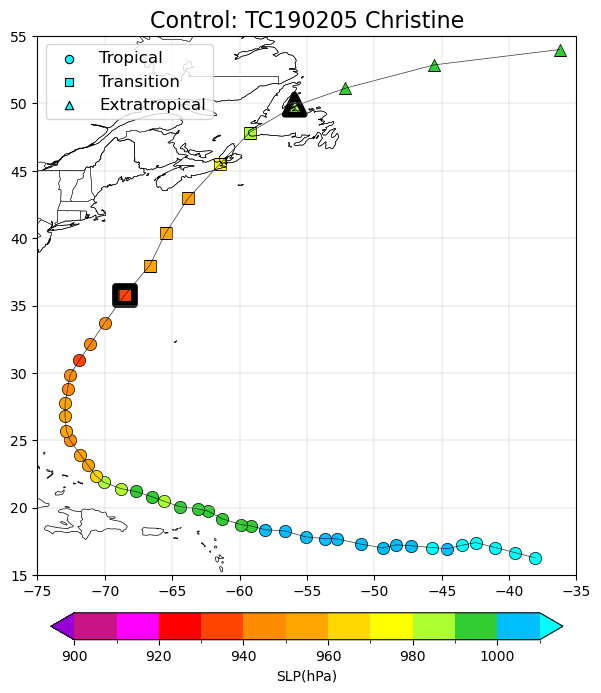

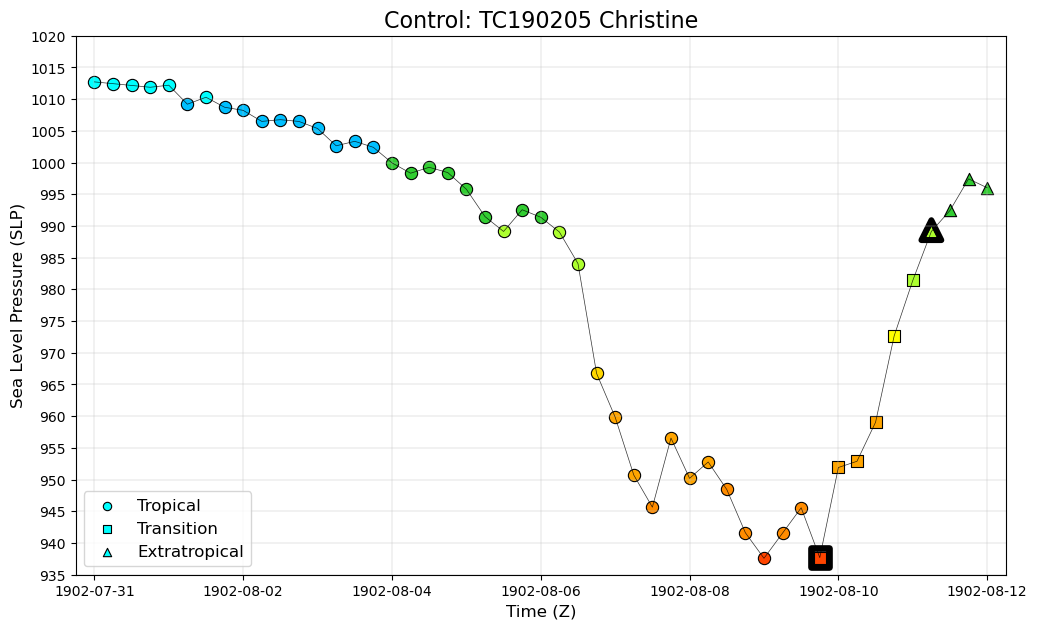

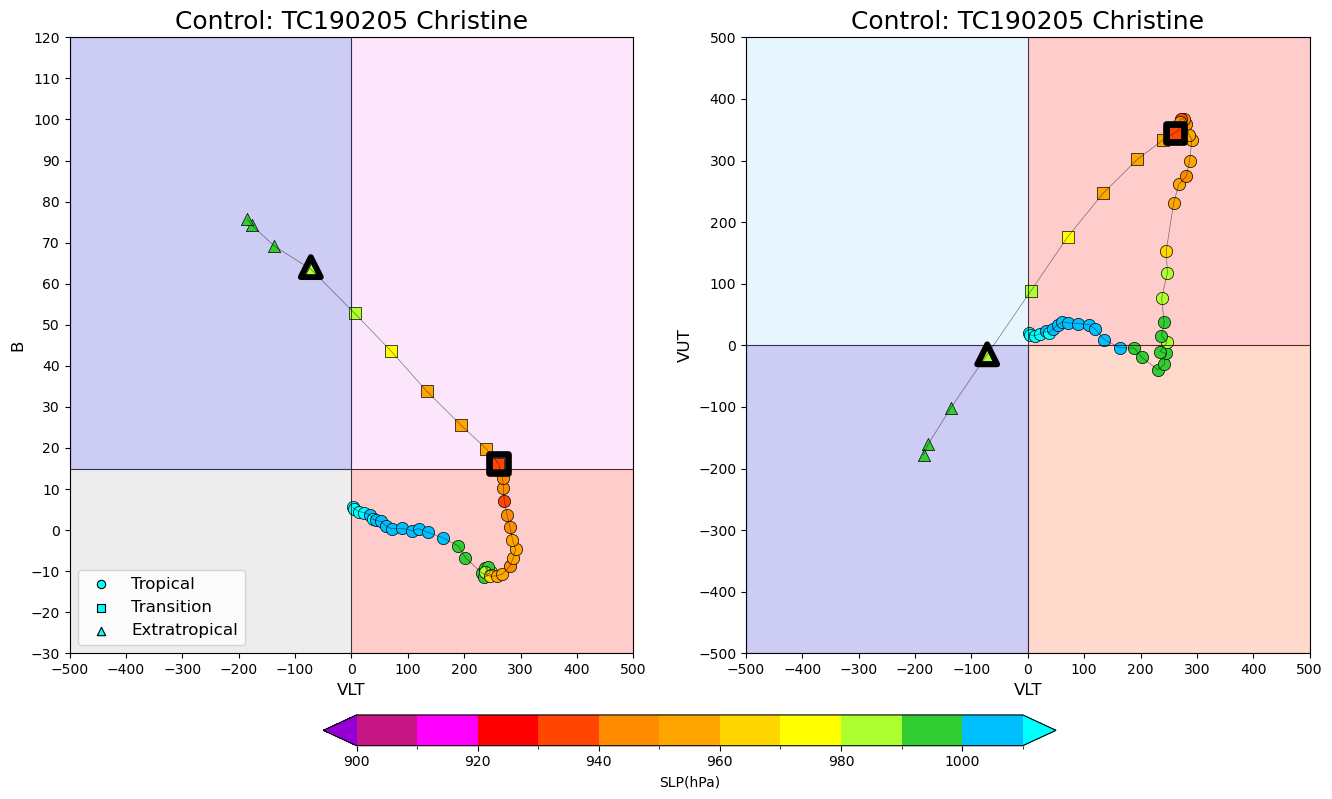

In [16]:
# Input Code
Code = 'TC190205'
Plot_Cyclone_Track(Code, Control_Data, Control_ET, SLP_Bounds, SLP_Colours, 2, True, "Control", False, (7,7))
Plot_Cyclone_SLP(Code, Control_Data, Control_ET, SLP_Bounds, SLP_Colours, 3, True, "Control", False)
Plot_Cyclone_Phase(Code, Control_Data, Control_ET, SLP_Bounds, SLP_Colours, 3, True, "Control", False)

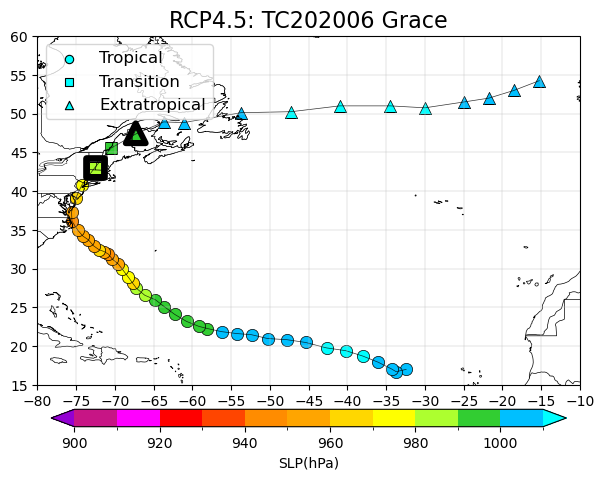

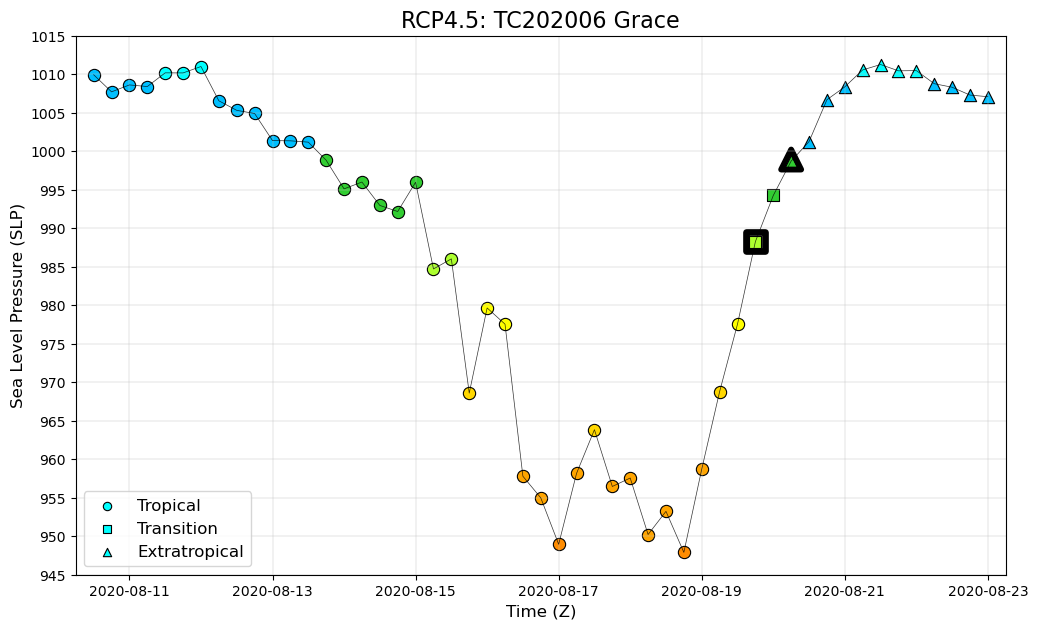

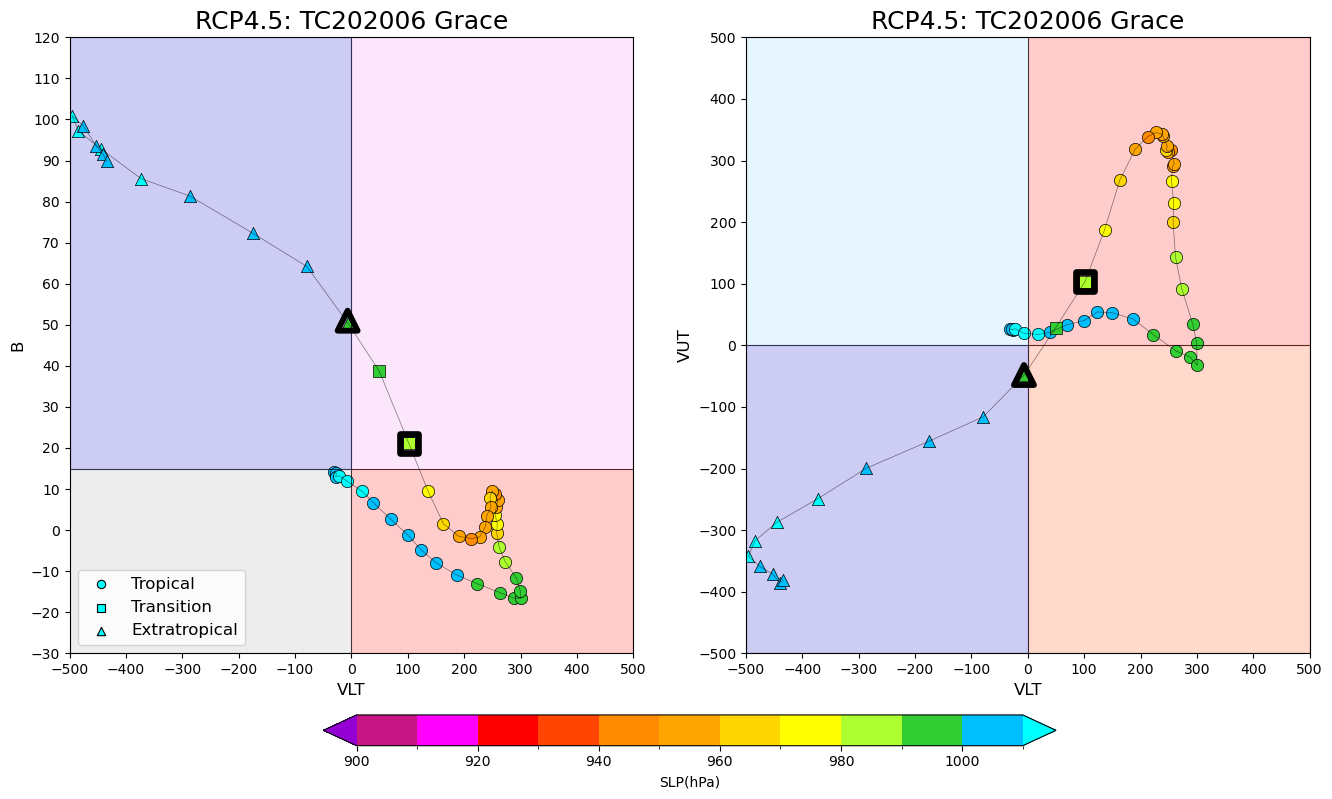

In [17]:
# Input Code
Code = 'TC202006'
Plot_Cyclone_Track(Code, RCP45_Data, RCP45_ET, SLP_Bounds, SLP_Colours, 2, True, "RCP4.5", False, (7,7))
Plot_Cyclone_SLP(Code, RCP45_Data, RCP45_ET, SLP_Bounds, SLP_Colours, 3, True, "RCP4.5", False)
Plot_Cyclone_Phase(Code, RCP45_Data, RCP45_ET, SLP_Bounds, SLP_Colours, 3, True, "RCP4.5", False)

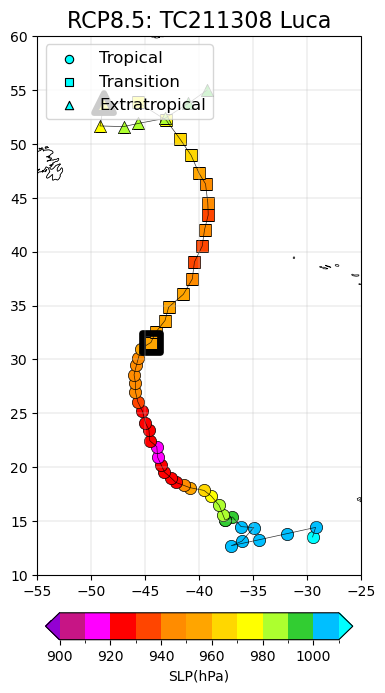

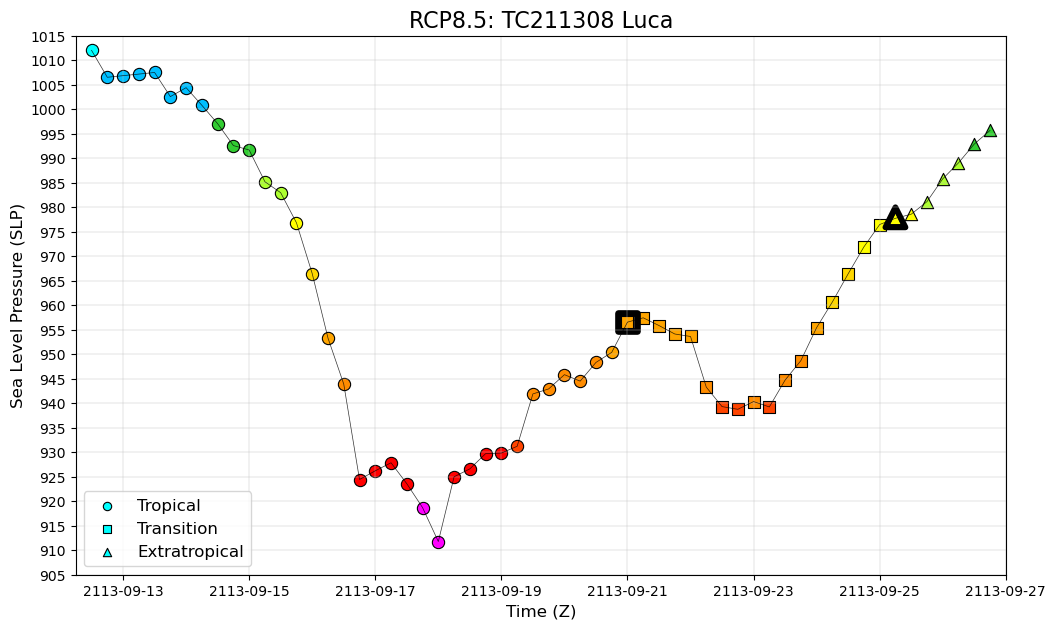

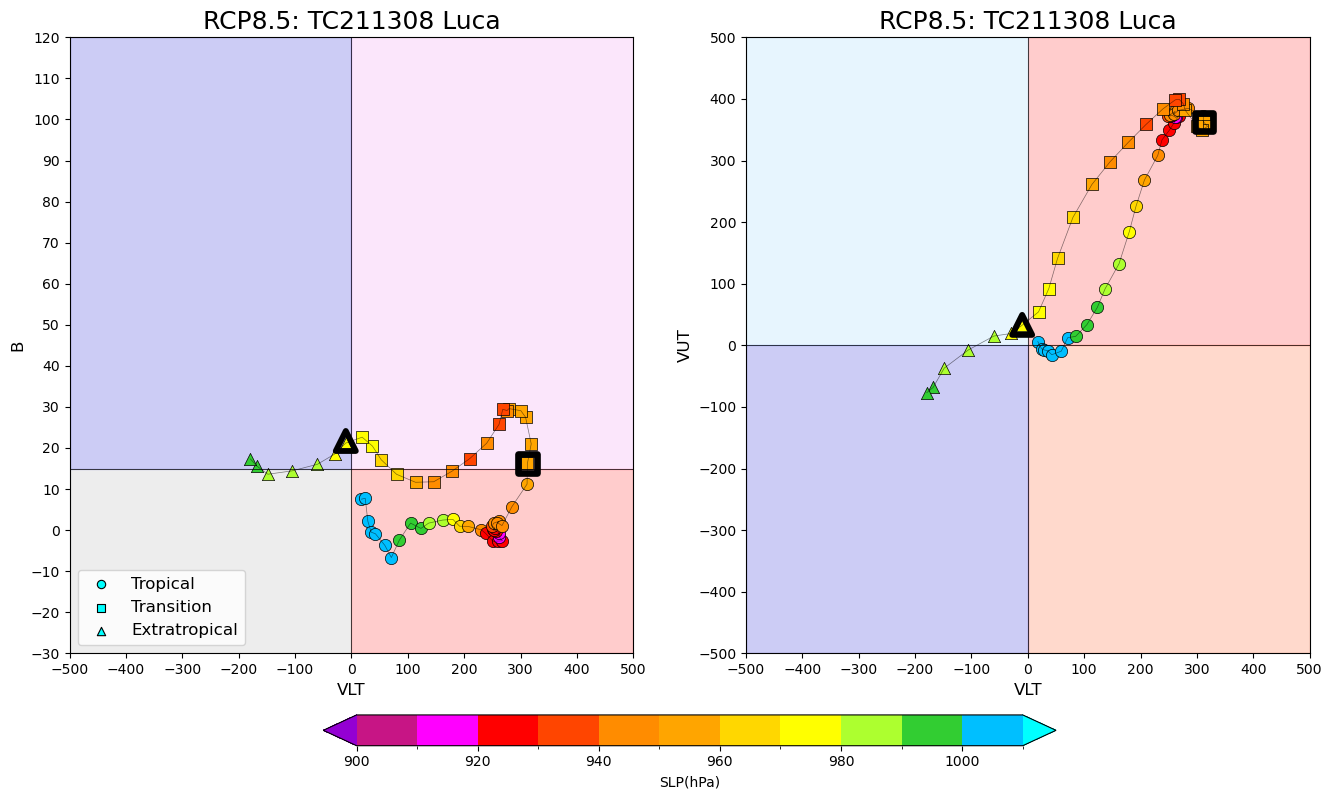

In [18]:
# Input Code
Code = 'TC211308'
Plot_Cyclone_Track(Code, RCP85_Data, RCP85_ET, SLP_Bounds, SLP_Colours, 2, True, "RCP8.5", False, (7,7))
Plot_Cyclone_SLP(Code, RCP85_Data, RCP85_ET, SLP_Bounds, SLP_Colours, 3, True, "RCP8.5", False)
Plot_Cyclone_Phase(Code, RCP85_Data, RCP85_ET, SLP_Bounds, SLP_Colours, 3, True, "RCP8.5", False)

In [19]:
# Input Code
#for i in range(len(Control_ET)):
#    Code = Control_ET["Code"][i]
#    if i >= 300 and i < 320:
#        Plot_Cyclone_Track(Code, Control_Data, Control_ET, SLP_Bounds, SLP_Colours, 4, True, "Control", False, (7,7))
#        Plot_Cyclone_Phase(Code, Control_Data, Control_ET, SLP_Bounds, SLP_Colours, 3, True, "Control", False)

In [20]:
# Input Code
#for i in range(len(RCP45_ET)):
#    Code = RCP45_ET["Code"][i]
#    if i >= 200 and i < 220:
#        Plot_Cyclone_Track(Code, RCP45_Data, RCP45_ET, SLP_Bounds, SLP_Colours, 4, True, "RCP4.5", False, (7,7))
#        Plot_Cyclone_Phase(Code, RCP45_Data, RCP45_ET, SLP_Bounds, SLP_Colours, 3, True, "RCP4.5", False)

In [21]:
# Input Code
#for i in range(len(RCP85_ET)):
#    Code = RCP85_ET["Code"][i]
#    if i >= 180 and i < 200:
#        Plot_Cyclone_Track(Code, RCP85_Data, RCP85_ET, SLP_Bounds, SLP_Colours, 4, True, "RCP8.5", False, (7,7))
#        Plot_Cyclone_Phase(Code, RCP85_Data, RCP85_ET, SLP_Bounds, SLP_Colours, 3, True, "RCP8.5", False)

In [22]:
Control_ET[Control_ET["Name"] == "Grace"]

,Code,Name,ABC,Trans Type,Genesis Time,ET Begin Time,ET Complete Time,Dissipate Time,Peak Time,Peak SLP,...,Genesis Lat,ET Begin SLP,ET Begin Lon,ET Begin Lat,ET Complete SLP,ET Complete Lon,ET Complete Lat,Dissipate SLP,Dissipate Lon,Dissipate Lat
246,TC197605,Grace,C,1,1976-09-01 06:00:00,1976-09-05 18:00:00,1976-09-08 06:00:00,1976-09-09,1976-09-08 06:00:00,982.04,...,21.96,999.61,-69.35,31.62,982.04,-61.9,46.82,990.62,-53.47,51.78


In [23]:
RCP45_ET[RCP45_ET["Name"] == "Grace"]

,Code,Name,ABC,Trans Type,Genesis Time,ET Begin Time,ET Complete Time,Dissipate Time,Peak Time,Peak SLP,...,Genesis Lat,ET Begin SLP,ET Begin Lon,ET Begin Lat,ET Complete SLP,ET Complete Lon,ET Complete Lat,Dissipate SLP,Dissipate Lon,Dissipate Lat
43,TC202006,Grace,A,1,2020-08-10 12:00:00,2020-08-19 18:00:00,2020-08-20 06:00:00,2020-08-23,2020-08-18 18:00:00,947.9,...,17.0,988.26,-72.59,43.04,998.72,-67.32,47.37,1007.08,-15.25,54.25


In [24]:
RCP85_ET[RCP85_ET["Name"] == "Grace"]

,Code,Name,ABC,Trans Type,Genesis Time,ET Begin Time,ET Complete Time,Dissipate Time,Peak Time,Peak SLP,...,Genesis Lat,ET Begin SLP,ET Begin Lon,ET Begin Lat,ET Complete SLP,ET Complete Lon,ET Complete Lat,Dissipate SLP,Dissipate Lon,Dissipate Lat
44,TC212401,Grace,A,2,2124-05-05,2124-05-07 18:00:00,2124-05-09 12:00:00,2124-05-13 18:00:00,2124-05-10,993.57,...,27.35,1007.47,-94.61,33.13,996.92,-86.36,41.4,1007.12,-57.75,37.25
